# Step 1: Organize Radiologist Reports into a Graph Database

In [1]:
import os
import pandas as pd
import re

### Set directory 
# Get the current working directory
current_working_dir = os.getcwd()

# Get the parent directory of the parent directory
base_dir = os.path.abspath(os.path.join(current_working_dir, "..", ".."))

# print("Current Working Directory:", current_working_dir)
# print("base_dir:", base_dir)

# Read the radiology reports
report_path = os.path.join(base_dir, 'ProgrammingTest_Data/Radiology Reports.pkl')
radiology_reports = pd.read_pickle(report_path)

In [2]:
# Analyze the report data

print(radiology_reports.columns)
print(radiology_reports.shape)
print(radiology_reports['PatientID'].unique)

Index(['fileID', 'PatientID', 'AccessionNumber', 'SeriesNumber',
       'InstanceNumber', 'Modality', 'bad_age', 'bad_quality', 'train',
       'ViewPosition', 'ap', 'pa', 'll', 'PatientSex', 'sex', 'PatientAge',
       'Manufacturer', 'varian', 'agfa', 'ge', 'others', 'PATH',
       'FULL_REPORT'],
      dtype='object')
(2000, 23)
<bound method Series.unique of 0       gAAAAABnXL-cwc7tIOfsqnun7c9yAKUkuJRKkkAxtajE-P...
1       gAAAAABnXL-c94U7vh9cdUeFCcFLojZgA6jsI8Hn75Gbsu...
2       gAAAAABnXL-c9c9VbbDCYax7GRg--yBTT-DOr02IxfKqNz...
3       gAAAAABnXL-cCVN8NXNa_daqjMdPicam5ZEIgIZKyaEcwZ...
4       gAAAAABnXL-cCcx236nsLHnwcEv_oyWrjJJ9Wdgg-bY55F...
                              ...                        
1995    gAAAAABnXL-c3AGgDJmNA5hJpAMj3dMVsgkxyXAjuSdAdA...
1996    gAAAAABnXL-cO_NaySQSRuZIG0irDJfJWLjt6ZDs4wAbAI...
1997    gAAAAABnXL-cnuz-CwrCmsgENBvAcYkwCXsl9XaucOmnKn...
1998    gAAAAABnXL-cKswF2500Y2uXoAnFtBr6EU0tA9WBlr3y_v...
1999    gAAAAABnXL-ctPaU6PhHXxN3r9umcvvlef3hpK5wQ5CWek.

In [3]:
# Add a columns for abberiate the PatientID
patient_ids = [f'Patient_{i:04d}' for i in range(1, 2001)]
radiology_reports.insert(0, 'PatientID_A', patient_ids)

In [4]:
print(radiology_reports.columns)
radiology_reports.to_csv('radiology_reports.csv')

Index(['PatientID_A', 'fileID', 'PatientID', 'AccessionNumber', 'SeriesNumber',
       'InstanceNumber', 'Modality', 'bad_age', 'bad_quality', 'train',
       'ViewPosition', 'ap', 'pa', 'll', 'PatientSex', 'sex', 'PatientAge',
       'Manufacturer', 'varian', 'agfa', 'ge', 'others', 'PATH',
       'FULL_REPORT'],
      dtype='object')


In [5]:
# Extract diseases from an example report

import spacy

# Load the scispaCy en_ner_bc5cdr_md model for biomedical named entity recognition
# The en_ner_bc5cdr_md model, provided by scispaCy, is specifically designed to 
# identify biomedical entities such as diseases and chemicals within scientific texts.
nlp = spacy.load("en_ner_bc5cdr_md")

# The radiology report text
report_text = """
A single AP view of the chest. COMPARISON: Portable single view chest [REDACTED] . FINDINGS: Lines/tubes: EKG leads overlying the field-of-view. Lungs: Low lung 
volumes. There are patchy airspace opacities at both lung bases. There is mild interstitial pulmonary edema. Pleura: There is no pleural effusion or pneumothorax.
Heart and mediastinum: The cardiomediastinal silhouette is stably enlarged, which may be related to technique. Bones: Thoracic skeleton is unchanged with scattered 
degenerative changes throughout. IMPRESSION: Bibasilar patchy airspace opacities, which in the appropriate clinical setting may represent atelectasis, aspiration 
or pneumonia. Mild interstitial pulmonary edema.
"""

# List of relevant labels in scispacy
relevant_labels_scispacy = ["DISEASE", "SYMPTOM", "FINDING"]

# Medical conditions in one piece of report
doc = nlp(report_text)
spacy_medical_conditions_in_example_report = [ent.text for ent in doc.ents if ent.label_ in relevant_labels_scispacy]
# print(f'spacy medical conditions in example report: {spacy_medical_conditions_in_example_report}')


# The function to extract medical conditions for a radiology report
def extract_spacy_medical_conditions(report):
    doc = nlp(report)
    # Extract terms with relevant labels from scispacy
    medical_conditions = [ent.text for ent in doc.ents if ent.label_ in relevant_labels_scispacy]
    return medical_conditions

# Extract medical conditions form all the reports in the Full_REPORT columns
spacy_medical_conditions_in_FULL_REPORTs = radiology_reports['FULL_REPORT'].apply(extract_spacy_medical_conditions)

# Generate a non-duplicate spacy medical condition list
spacy_medical_conditions_in_FULL_REPORTs = [term for sublist in spacy_medical_conditions_in_FULL_REPORTs for term in sublist]
spacy_medical_conditions_in_FULL_REPORTs = list(set(spacy_medical_conditions_in_FULL_REPORTs))

# print(f'spacy medical conditions in all the reports in the Full_REPORT columns: {spacy_medical_conditions_in_FULL_REPORTs}')

/opt/anaconda3/lib/python3.12/site-packages/spacy/language.py:2195: FutureWarning: Possible set union at position 6328
  deserializers["tokenizer"] = lambda p: self.tokenizer.from_disk(  # type: ignore[union-attr]


In [6]:
# Save the 'spacy_medical_conditions_in_FULL_REPORTs' list file
spacy_medical_conditions_in_FULL_REPORTs_df = pd.DataFrame(spacy_medical_conditions_in_FULL_REPORTs)
spacy_medical_conditions_in_FULL_REPORTs_df.insert(0, 'Index', range(len(spacy_medical_conditions_in_FULL_REPORTs_df)))
spacy_medical_conditions_in_FULL_REPORTs_df.columns = ['Index', 'Terms']
spacy_medical_conditions_in_FULL_REPORTs_df.to_csv('spacy_medical_conditions_in_FULL_REPORTs.csv')
print(f"The list of unique medical terms has been saved to 'spacy_medical_conditions_in_FULL_REPORTs.csv")

# with open('spacy_medical_conditions_in_FULL_REPORTs.json', 'w') as file:
#     json.dump(spacy_medical_conditions_in_FULL_REPORTs, file)

# print(f"The list of unique medical terms has been saved to 'spacy_medical_conditions_in_FULL_REPORTs.json")

The list of unique medical terms has been saved to 'spacy_medical_conditions_in_FULL_REPORTs.csv


In [7]:
# Define disease, abnornality, lesion, and location.
# (1) Extract all terms of medical conditions from the Full_REPORT column with spacy "en_ner_bc5cdr_md" model
# (2) Ref: https://radiologyassistant.nl/chest/chest-x-ray/lung-disease
# (3) Ref: https://www.ncbi.nlm.nih.gov/mesh?Db=mesh&Cmd=DetailsSearch&Term=%22Lung+Diseases%22%5BMeSH+Terms%5D

diseases = ['chronic obstructive pulmonary disease', 'COPD', 'pulmonary fibrosis', 'cystic fibrosis', 'pneumonia', 'bronchopneumonia', 'peripheral pneumonia',
            'cancer', 'lung cancer', 'mesothelioma', 'carcinomatosis', 'primary lung neoplasm', 'AML', 'pulmonary artery hypertension', 'pulmonary hypertension', 
            'pulmonary arterial hypertension', 'pulmonary venous hypertension', 'chronic cardiopulmonary disease', 'ARDS', 'Congestive Heart Failure','CHF', 
            'diastolic heart fail', 'lung abscess', 'radiation pneumonitis', 'bronchitis', 'degenerative disease', 'obstructive pneumonia', 'postobstructive pneumonia',
            'interstitial pulmonary fibrosis', 'marfan syndrome', 'bochdalek hernia', 'hiatal hernia']

abnormalities = ['opacity', 'opacities', 'opacification', 'nodular opacities', 'left basilar opacities', 'right bibasilar opacities', 'right basilar opacities', 
                 'bibasilar patchy opacities', 'interstitial airspace opacities', 'bibasilar opacity', 'hazy basilar opacity', 'lower lobe opacities',
                 'bibasilar hazy', 'airspace opacification', 'left basilar opacity', 'streaky bibasilar opacities', 'interstitial opacities',
                 'interstitial opacifications', 'reticular nodular opacities', 'hazy bibasilar opacities', 'heterogeneous opacities',
                 'left hemidiaphragm', 'basilar patchy opacifications',
                   
                 'enlargement of the right pulmonary artery','enlarged main pulmonary artery', 'enlarged cardiac silhouette', 'right thyroid enlargement', 
                 'enlargement of cardiomediastinal silhouette', 'enlargement of the cardiac', 'fullness of the superior mediastinum', 'right hilar enlargement',
                 'enlarged central pulmonary arteries', 'patulous esophagus', 'thyroid enlargement', 'aneurysmal dilatation', 'enlargement of the aorta', 
                 'Cardiac enlargement', 'enlarged thoracic aorta', 'enlargement of the RIGHT', 'enlargement of the cardiac mediastinal silhouette', 
                 'enlargement the cardiac silhouette', 'enlargement of the cardiomediastinal', 'enlargement of the cardiac silhouette status post',
                 'enlargement of the cardia', 'left hilar adenopathy', 'perihilar fullness',
                   
                   
                 'atelectasis','bibasilar segmental atelectasis', 'bibasilar relaxation atelectasis', 'lower lobe subsegmental atelectasis', 'volume loss', 
                 'left bibasilar atelectasis', 'middle lobe atelectasis', 'basilar subsegmental atelectasis', 'lingular atelectasis', 'subsegmental atelectasis',
                 'bibasal atelectasis', 'postoperative atelectasis', 'discoid atelectasis', 'retrocardiac atelectasis', 'left retrocardiac atelectasis',
                 'right basilar atelectasis', 'lower lobe atelectasis', 'bibasilar subsegmental atelectasis', 'basilar discoid atelectatic', 'lucency'
                 'left basilar nodular atelectasis', 'low lung volumes', 'decreased crescentic lucency', 'nonvisualization of the left', 'relaxation atelectasis',

                 'interstitial disease', 'interstitial lung disease', 'interstitial abnormality',
                   
                 'pulmonary interstitial edema','alveolar edema', 'pulmonary edema', 'airspace pulmonary edema', 'basilar airspace disease', 'upper lobe emphysema',
                 'acute airspace disease', 'lower lobe airspace disease', 'interstitial edema', 'intra-alveolar pulmonary edema', 'fluid overload','asymmetric edema',
                 'asymmetric alveolar edema','asymmetric pulmonary edema', 'interstitial pulmonary edema', 'interstitial and alveolar pulmonary edema',
                   
                 'emphysema', 'emphysematous change', 'chest wall emphysema', 'Subcutaneous venous emphysema', 'hyperinflated',
                 'hyperlucent', 'hyperinflated lungs', 'lungs right greater',
                 'pneumothorax', 'hydropneumothorax', 'upper lobe hyperinflation',
                   
                 'hemorrhage', 'pulmonary hemorrhage', 'hemothorax', 'alveolar damage',
                   
                 'pleural effusion', 'left and small right pleural effusion', 'small pleural effusions', 'pleural effusions right', 'pleural effusions blunt',
                 'bibasilar pleural effusions', 'right effusion', 'left-sided small pleural effusion', 'subpulmonic pleural effusion',
                   
                 'nodularity', 'multiple pulmonary nodules',
                 'fibrosis', 'cystic change', 'calculus', 
                 'degenerative changes', 'thoracic degenerative', 'osteopenia', 'hiatus hernia', 'thoracic adenopathy', 'nipple shadows', 'depressed',
                 'infection', 'aspiration', 'ectasia', 'airway obstruction', 'obstruction or pseudoobstruction', 'diverticulitis', 'pleural sinus tract',
                 'cardiomegaly', 'interlobular septal thickening', 'substernal goiter', 'loop of bowel', 'lymphadenopathy',
                   
                 'calcification', 'calcifications', 'Atherosclerotic', 'atherosclerotic calcifications', 'artery calcific', 'atherosclerosis calcifications',
                 'coarse atherosclerotic calcifications', 'aortic atherosclerotic calcifications', 'vascular calcifications', 'calcifications of the thoracic aorta',
                 'atherosclerotic vascular calcifications', 'atherosclerotic ossifications', 'therosclerotic aortic calcifications', 'coronary artery calcifications'
                 'atherosclerotic aortic calcifications', 'pleural calcifications', 'calcification of the aorta', 'Pericardial calcifications', 'atherosclerosis',
                   
                 'aortic tortuosity', 'tortuous thoracic aorta', 'innominate artery tortuosity', 'obscuration of hilar vasculature', 'azygos fissure',
                 'pulmonary vascular fullness', 'thoracic aortic dissection', 'loss of pulmonary vascular', 'crowding of pulmonary vascular', 'aneurysmal'
                 'pulmonary artery shadows', 'thoracic aortic tortuosity','vascular congestion', 'perihilar congestion', 'pulmonary vascular congestion'
                 'pulmonary venous engorgement',
                   
                 'deformity', 'heterogeneous pleural thickening', 'posttraumatic deformity', 'left-sided rib fractures', 'levoscoliosis','acute osseous abnormality',
                 'fracture deformities', 'rib fracture deformities', 'compression deformities', 'left clavicular fracture deformity', 'postoperative contusion',
                 'thoracic compression', 'kyphoscoliosis', 'kyphosis', 'thoracic kyphosis', 'pectus carinatum deformity', 'right anterior shoulder dislocation',
                 'thoracic vertebral compression fracture', 'compression deformities of thoracic spine', 'Compression deformities of T8 and T9', 'dextroscoliosis',
                 'dextroconvex thoracic curvature', 'T7 compression', 'glenohumeral subluxation', 'thoracic compression deformities', 'Thoracolumbar spine scoliosis',
                 'pectus excavatum deformity', 'fractures', 'compression deformities of T5-T8, T12, and L1', 'left rib fracture deformities', 'sternal fracture',
                 'subluxation', 'displaced rib fractures', 'traumatic deformity',
                 'clavicular fracture', 'thoracic dextroscoliosis', 'humeral head sclerosis', 'demineralization of the skeleton', 'thoracolumbar scoliosis',
                 'DJD', 'rotator cuff injury', 'trauma', 'thoracic trauma', 'osteopenia',
                   ]

lesions = ['cyst', 'nodule', 'nodules', 'multiple pulmonary nodules', 'granuloma', 'calcified granuloma', 'ulcer', 'abscess', 'lesion', 'cavitary lesion', 
           'tumor', 'mass']

locations = ['right lung', 'left lung', 'upper', 'middle', 'lower', 'left upper', 'right upper', 'apical', 'basal', 'lingula', 'left basilar', 
             'right basilar', 'bibasilar',
             'anterior segment', 'posterior segment', 'lateral segment', 'medial segment', 'superior segment', 'inferior segment', 'left apex', 'right apex'
             'midlung', 'pleural', 'pleural space', 'pleural cavity', 'parietal pleura', 'visceral pleura',
             'mediastinum', 'mediastinumal', 'anterior mediastinum', 'middle mediastinum', 'posterior mediastinum', 'anterior mediastinumal', 'middle mediastinumal', 
             'posterior mediastinumal', 'suprahilar/mediastinal',
             'right hemidiaphragm', 'left hemidiaphragm',
             'cardiac silhouette', 'aorta', 'aortic arch', 'pulmonary artery', 'left pulmonary artery', 'right pulmonary artery', 'superior vena cava', 
             'inferior vena cava', 'hilar region', 'left hilar', 'right hilar'
             'thoracic spine', 'right hilum', 'left hilum', 'costophrenic angle', 'cardiophrenic angle', 'retrocardiac area', 'perihilar region', 
             'rib', 'sternum', 'clavicles', 'thoracic Spine',
             'subpulmonic space', 
             'adjacent to the descending branch of the left pulmonary artery', 'right glenohumeral joint']

negative_phrases = [
    "no evidence of", "no evidence for", "no", "without", "negative for", "free of", "not", "absence of"
]

In [8]:
### An example of extracting information from a single FULL_REPORT


# Function to split the text into sentences
def split_into_sentences(text):
    return re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', text)

# Function to find target_terms (diseases, abnormalities, lesions, or locations) using regular expressions in a individual sentence in a report.
def find_target_term(target_term, sentence_text):
    # \b is a word boundary, ensuring that we match whole words
    pattern = rf'\b{re.escape(target_term)}\b'
    return re.search(pattern, sentence_text)

# Function to exclude target terms in negative context
def is_negative_context(sentence_text, target_term):
    for negative_phrase in negative_phrases:
        if re.search(rf'\b{re.escape(negative_phrase)}\b', sentence_text, re.IGNORECASE):
            return True
    return False

# Function to remove general term (abnormality,location, etc.) if more specific term exist
def find_specific_term(term_list):
    # Sort the terms by length in descending order
    term_list.sort(key=len, reverse=True)
    if term_list == ['opacity']:
        print(f'term_list = {term_list}')
    filtered_terms = []
    for i, term in enumerate(term_list):
        is_substring = False
        for j in range(len(term_list)):
            if i != j and term in term_list[j]:
                is_substring = True
                break
        if not is_substring:
            filtered_terms.append(term)    
    return filtered_terms
    
def find_specific_terms(term_list):
    # Sort the terms by length in descending order
    term_list.sort(key=len, reverse=True)
    
    filtered_terms = []
    for i, term in enumerate(term_list):
        is_substring = False
        for j in range(len(term_list)):
            if i != j and term in term_list[j]:
                is_substring = True
                break
        if not is_substring:
            filtered_terms.append(term)
    
    return filtered_terms
    
# Function to find size
def find_size(sentence_text):
    # Define a regular expression pattern to match sizes
    size_pattern = re.compile(r'\b(\d+(\.\d+)?)\s*(cm|mm|millimeter|millimeters|centimeter|centimeters)\b')
    # Search for sizes in the report text
    sizes = size_pattern.findall(sentence_text)   
    # Extract the sizes and units
    extracted_sizes = [f"{match[0]} {match[2]}" for match in sizes]
     # Define additional size descriptors
    additional_sizes = ['small', 'medium', 'large']
    # Search for additional size descriptors in the sentence text
    for size in additional_sizes:
        if re.search(rf'\b{size}\b', sentence_text, re.IGNORECASE):
            extracted_sizes.append(size)
    return extracted_sizes
    
# Function to join list elements into a single string
def join_list_elements(lst):
    return ', '.join(lst) if lst else None
            


## Extract the Patient ID and Full_REPORT from a row in radiology_reports; split the Full_REPORT in to individual stentents; extract diseases, abnormalities,
## locations, and sizes from the stetence; make a DataFrame for the extracted information. 
patient_id = radiology_reports.loc[99, 'PatientID_A']
report_text = radiology_reports.loc[99, 'FULL_REPORT'] 
# Normalize the report text to lower case for case-insensitive matching
normalized_report_text = report_text.lower()
# Print the report
print(f'report_text: {report_text}, \n')

# Split the text into sentences
sentences = split_into_sentences(normalized_report_text)

# define an empty DataFrame
columns = ['PatientID_A', 'Disease', 'Abnormality', 'Abnormality_size', 'Lesion', 'Lesion_location', 'Lesion_size']
df = pd.DataFrame(columns=columns)

for sentence in sentences:
    sentence_lower = sentence.lower()
    # Find disease in the sentence
    found_diseases = []
    for disease in diseases:
        disease_lower = disease.lower()
        if find_target_term(disease_lower, sentence_lower):
            if not is_negative_context(sentence_lower, disease_lower):
               found_diseases.append(disease)

    # Find abnormalities in sentence
    found_abnormalities = []
    for abnormality in abnormalities:
        abnormality_lower = abnormality.lower()
        if find_target_term(abnormality_lower, sentence_lower):
            if not is_negative_context(sentence_lower, abnormality_lower):
                found_abnormalities.append(abnormality)

    # Remove the more general abnormalities if there is more specific abnormalilites 
    filtered_abnormalities = find_specific_terms(found_abnormalities)
    
    # Find abnormality size
    abnormality_size = []
    if filtered_abnormalities:
        abnormality_size = find_size(sentence_lower)

    # Find lesions in sentence
    found_lesions= []
    for lesion in lesions:
        lesion_lower = lesion.lower()
        if find_target_term(lesion_lower, sentence_lower):          
            if not is_negative_context(sentence_lower, lesion_lower):
                found_lesions.append(lesion)

    # Find lesion locations 
    found_lesion_locations = []
    if found_lesions:        
        for location in locations:
            location_lower = location.lower()
            if find_target_term(location_lower, sentence_lower):
                found_lesion_locations.append(location)
                
    # Remove the more general locations if there is more specific locations 
    filtered_lesion_locations = find_specific_terms(found_lesion_locations)
    
    # Find lesion size
    lesion_size = []
    if found_lesions:
        lesion_size = find_size(sentence_lower)
    
    
    # Join list elements into a single string for each extract information
    if found_diseases or filtered_abnormalities or found_lesions:
        joined_diseases = join_list_elements(found_diseases)
        joined_abnormalities = join_list_elements(filtered_abnormalities)
        joined_abnormality_size = join_list_elements(abnormality_size)
        joined_lesions = join_list_elements(found_lesions)
        joined_lesion_locations = join_list_elements(filtered_lesion_locations)
        joined_lesion_size = join_list_elements(lesion_size)
    
        # Create a new row as a DataFrame
        new_row = pd.DataFrame({
            'PatientID_A': [patient_id],
            'Disease': [joined_diseases],
            'Abnormality': [joined_abnormalities],
            'Abnormality_size': [joined_abnormality_size],
            'Lesion': [joined_lesions],
            'Lesion_location': [joined_lesion_locations],
            'Lesion_size': [joined_lesion_size]
        })
    
        # Concatenate the new row with the original DataFrame
        df = pd.concat([df, new_row], ignore_index=True)

print(f'df = {df}')

report_text: Frontal and lateral views of the chest.   COMPARISON: XR CHEST PA AND LATERAL 2 VIEWS [REDACTED] .   FINDINGS:  Lines/tubes:  None.   Lungs:  There are low lung volumes. There is elevation of the left hemidiaphragm, unchanged from prior. There is a patchy left basilar opacity.   Pleura:  There is no pleural effusion or pneumothorax.   Heart and mediastinum:  There is a moderate hiatal hernia.   Bones:  There are diffuse degenerative changes of the bony thorax and osteopenia.   IMPRESSION:  Moderate hiatal hernia.   Patchy left basilar opacity, possibly representing a focus of aspiration, atelectasis, or pneumonia.   , 

df =     PatientID_A        Disease                                    Abnormality  \
0  Patient_0100           None                               low lung volumes   
1  Patient_0100           None                             left hemidiaphragm   
2  Patient_0100           None                           left basilar opacity   
3  Patient_0100  hiatal hernia

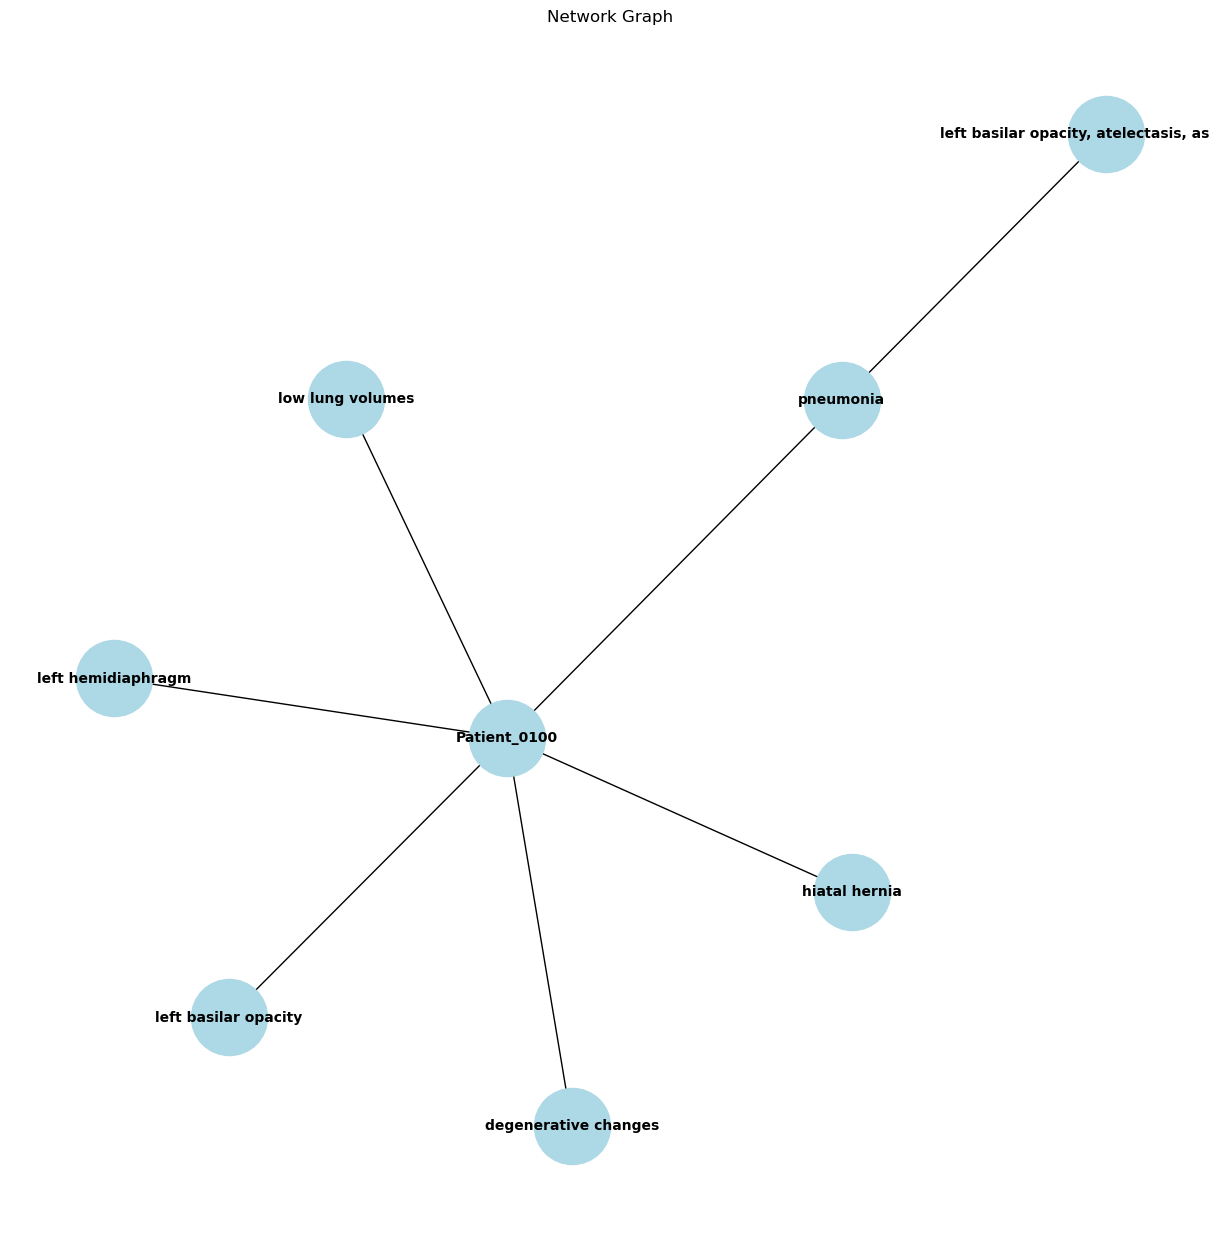

In [9]:
## The example of constructing a graphic network

import networkx as nx_example
import matplotlib.pyplot as plt

# Create an empty graph
G = nx_example.Graph()

# Function to add a node if the value is not None or empty
def add_node_if_not_empty(graph, node_value, node_type):
    if node_value:  # Check if the value is not None or empty
        graph.add_node(node_value, type=node_type)

# Function to add a edge if the both valuea are not None or empty
def add_edge_if_non_empty(graph, node1_value, node2_value, nodes_relationship):
    if node1_value and node2_value:  # Check if the two node values are not None or empty
        graph.add_edge(node1_value, node2_value, relationship=nodes_relationship)
        
## Add node and edge based on the DataFrame
for i, row in df.iterrows():
    # Add notes
    add_node_if_not_empty(G, df.loc[i, 'PatientID_A'], 'patient')
    add_node_if_not_empty(G, df.loc[i, 'Disease'], 'disease')
    add_node_if_not_empty(G, df.loc[i, 'Abnormality'], 'abnormality')
    add_node_if_not_empty(G, df.loc[i, 'Abnormality_size'], 'Abnormality_size')
    add_node_if_not_empty(G, df.loc[i, 'Lesion'], 'lesion')
    add_node_if_not_empty(G, df.loc[i, 'Lesion_location'], 'lesion_location')
    add_node_if_not_empty(G, df.loc[i, 'Lesion_size'], 'lesion_size')
    
    # Add relationships (edges)
    if df.loc[i, 'Disease']:
        add_edge_if_non_empty(G, df.loc[i, 'PatientID_A'], df.loc[i, 'Disease'], 'HAS_DIAGNOSIS')
    elif not df.loc[i, 'Disease'] and df.loc[i, 'Abnormality'] and not df.loc[i, 'Lesion']:
        add_edge_if_non_empty(G, df.loc[i, 'PatientID_A'], df.loc[i, 'Abnormality'], 'HAS_ABNORMALITY')
    elif not df.loc[i, 'Disease'] and not df.loc[i, 'Abnormality'] and df.loc[i, 'Lesion']:
        add_edge_if_non_empty(G, df.loc[i, 'PatientID_A'], df.loc[i, 'lesion'], 'HAS_LESION')
    elif not df.loc[i, 'Disease'] and df.loc[i, 'Abnormality'] and df.loc[i, 'Lesion']:
        add_edge_if_non_empty(G, df.loc[i, 'PatientID_A'], df.loc[i, 'Abnormality'], 'HAS_ABNORMALITY')
        add_edge_if_non_empty(G, df.loc[i, 'PatientID_A'], df.loc[i, 'lesion'], 'HAS_LESION')
    add_edge_if_non_empty(G, df.loc[i, 'Disease'], df.loc[i, 'Abnormality'], 'HAS_ABNORMALITY')
    add_edge_if_non_empty(G, df.loc[i, 'Abnormality'], df.loc[i, 'Abnormality_size'], 'HAS_SIZE')
    add_edge_if_non_empty(G, df.loc[i, 'Disease'], df.loc[i, 'Lesion'], 'HAS_Lesion')
    add_edge_if_non_empty(G, df.loc[i, 'Lesion'], df.loc[i, 'Lesion_location'], 'HAS_LOCATION')
    add_edge_if_non_empty(G, df.loc[i, 'Lesion'], df.loc[i, 'Lesion_size'], 'HAS_SIZE')

# Plot the graph
pos = nx_example.spring_layout(G)  # Position nodes using Fruchterman-Reingold force-directed algorithm
labels = nx_example.get_edge_attributes(G, 'label')

plt.figure(figsize=(12, 12))
nx_example.draw(G, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=10, font_weight='bold')
plt.title("Network Graph")
plt.show()

In [15]:
### Extracting information and construct the graphic network for the all the radiology_reports

import networkx as nx
import json
from networkx.readwrite import json_graph

# Function to split the text into sentences
def split_into_sentences(text):
    return re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', text)

# Function to find target_terms (diseases, abnormalities, lesions, or locations) using regular expressions in a individual sentence in a report.
def find_target_term(target_term, sentence_text):
    # \b is a word boundary, ensuring that we match whole words
    pattern = rf'\b{re.escape(target_term)}\b'
    return re.search(pattern, sentence_text)

# Function to exclude target terms in negative context
def is_negative_context(sentence_text, target_term):
    for negative_phrase in negative_phrases:
        if re.search(rf'\b{re.escape(negative_phrase)}\b', sentence_text, re.IGNORECASE):
            return True
    return False

# Function to remove general term (abnormality,location, etc.) if more specific term exist
def find_specific_terms(term_list):
    # Sort the terms by length in descending order
    term_list.sort(key=len, reverse=True)    
    filtered_terms = []
    for i, term in enumerate(term_list):
        is_substring = False
        for j in range(len(term_list)):
            if i != j and term in term_list[j]:
                is_substring = True
                break
        if not is_substring:
            filtered_terms.append(term)    
    return filtered_terms
    
# Function to find size
def find_size(sentence_text):
    # Define a regular expression pattern to match sizes
    size_pattern = re.compile(r'\b(\d+(\.\d+)?)\s*(cm|mm|millimeter|millimeters|centimeter|centimeters)\b')
    # Search for sizes in the report text
    sizes = size_pattern.findall(sentence_text)   
    # Extract the sizes and units
    extracted_sizes = [f"{match[0]} {match[2]}" for match in sizes]
     # Define additional size descriptors
    additional_sizes = ['small', 'medium', 'large']
    # Search for additional size descriptors in the sentence text
    for size in additional_sizes:
        if re.search(rf'\b{size}\b', sentence_text, re.IGNORECASE):
            extracted_sizes.append(size)
    return extracted_sizes
    
# Function to join list elements into a single string
def join_list_elements(lst):
    return ', '.join(lst) if lst else None

# Function to add a node if the value is not None or empty
def add_node_if_not_empty(graph, node_value, node_type):
    if node_value:  # Check if the value is not None or empty
        graph.add_node(node_value, type=node_type)

# Function to add a edge if the both valuea are not None or empty
def add_edge_if_non_empty(graph, node1_value, node2_value, nodes_relationship):
    if node1_value and node2_value:  # Check if the two node values are not None or empty
        graph.add_edge(node1_value, node2_value, relationship=nodes_relationship)



### Extract the Patient ID and Full_REPORT from a row in radiology_reports; split the Full_REPORT in to individual stentents; extract diseases, abnormalities,
### locations, and sizes from the stetence; make a DataFrame for the extracted information. 
## define an empty DataFrame to store all the extracted information
columns = ['PatientID_A', 'Disease', 'Abnormality', 'Abnormality_size', 'Lesion', 'Lesion_location', 'Lesion_size']
df0 = pd.DataFrame(columns=columns)

## Define a dictionary to store the graphs, with Patient IDs as keys
graphs_dict = {}
xray_image_dir = os.path.join(base_dir, "ProgrammingTest_Data/png")

## Extract information from each individual patient reports and construct network graphs for them 
for index, row in radiology_reports.iterrows():
    patient_id = row['PatientID_A']
    report_text = row['FULL_REPORT'] 
    xray_image_filename = row['PATH']
    
    # Normalize the report text to lower case for case-insensitive matching
    normalized_report_text = report_text.lower()
    
    # Split the text into sentences
    sentences = split_into_sentences(normalized_report_text)
    
    # define an empty DataFrame to store the extracted information of an individul row (for one patient) in the radiology_reports and constructing the graphic network
    df = pd.DataFrame(columns=columns)
    
    for sentence in sentences:
        sentence_lower = sentence.lower()
        
        # Find disease in the sentence
        found_diseases = []
        for disease in diseases:
            disease_lower = disease.lower()
            if find_target_term(disease_lower, sentence_lower):
                if not is_negative_context(sentence_lower, disease_lower):
                   found_diseases.append(disease)
    
        # Find abnormalities in sentence
        found_abnormalities = []
        for abnormality in abnormalities:
            abnormality_lower = abnormality.lower()
            if find_target_term(abnormality_lower, sentence_lower):
                if not is_negative_context(sentence_lower, abnormality_lower):
                    found_abnormalities.append(abnormality)
        # Remove the more general abnormalities if there is more specific abnormalilites 
        filtered_abnormalities = find_specific_terms(found_abnormalities)
        
        # Find abnormality size in sentence
        abnormality_size = []
        if filtered_abnormalities:
            abnormality_size = find_size(sentence_lower)
    
        # Find lesions in sentence
        found_lesions= []
        for lesion in lesions:
            lesion_lower = lesion.lower()
            if find_target_term(lesion_lower, sentence_lower):          
                if not is_negative_context(sentence_lower, lesion_lower):
                    found_lesions.append(lesion)
    
        # Find lesion locations in sentence
        found_lesion_locations = []
        if found_lesions:        
            for location in locations:
                location_lower = location.lower()
                if find_target_term(location_lower, sentence_lower):
                    found_lesion_locations.append(location)                    
        # Remove the more general locations if there is more specific locations 
        filtered_lesion_locations = find_specific_terms(found_lesion_locations)
    
        # Find lesion size
        lesion_size = []
        if found_lesions:
            lesion_size = find_size(sentence_lower)
        
        
        # Join list elements into a single string for each extract information from one sentence
        if found_diseases or filtered_abnormalities or found_lesions:
            joined_diseases = join_list_elements(found_diseases)
            joined_abnormalities = join_list_elements(filtered_abnormalities)
            joined_abnormality_size = join_list_elements(abnormality_size)
            joined_lesions = join_list_elements(found_lesions)
            joined_lesion_locations = join_list_elements(filtered_lesion_locations)
            joined_lesion_size = join_list_elements(lesion_size)
        
            # Create a new row as a DataFrame
            new_row = pd.DataFrame({
                'PatientID_A': [patient_id],
                'Disease': [joined_diseases],
                'Abnormality': [joined_abnormalities],
                'Abnormality_size': [joined_abnormality_size],
                'Lesion': [joined_lesions],
                'Lesion_location': [joined_lesion_locations],
                'Lesion_size': [joined_lesion_size]
            })
            
            # Concatenate the new row for one sentence with the original DataFrame 
            df = pd.concat([df, new_row], ignore_index=True)
    
    # Check if df (at the lelve of a report) is empty
    if df.empty:
        # Create a row with all values being empty (None)
        new_row = pd.DataFrame([{col: None for col in columns}])
        new_row['PatientID_A'] = patient_id
        # Alternatively, use empty strings instead of None
        # empty_row = {col: "" for col in columns}
        
        # Append the empty row to the DataFrame
        df = pd.concat([df, new_row], ignore_index=True)


    ## Append df to df0
    df0 = pd.concat([df0, df])
  
    ## Construct the graphic network
    # Create an empty graph
    G = nx.Graph()

    # Create a graph for each patient
    add_node_if_not_empty(G, patient_id, 'patient')
    add_node_if_not_empty(G, xray_image_filename, 'X-ray image')
    add_edge_if_non_empty(G, patient_id, xray_image_filename, 'HAS_IMAGE')
    
    for i, row_df in df.iterrows(): 
        # Add more notes     
        add_node_if_not_empty(G, df.loc[i, 'Disease'], 'disease')
        add_node_if_not_empty(G, df.loc[i, 'Abnormality'], 'abnormality')
        add_node_if_not_empty(G, df.loc[i, 'Abnormality_size'], 'Abnormality_size')
        add_node_if_not_empty(G, df.loc[i, 'Lesion'], 'lesion')
        add_node_if_not_empty(G, df.loc[i, 'Lesion_location'], 'lesion_location')
        add_node_if_not_empty(G, df.loc[i, 'Lesion_size'], 'lesion_size')      
        
        # Add relationships (edges)
        if df.loc[i, 'Disease']:
            add_edge_if_non_empty(G, df.loc[i, 'PatientID_A'], df.loc[i, 'Disease'], 'HAS_DIAGNOSIS')
        elif not df.loc[i, 'Disease'] and df.loc[i, 'Abnormality']:
            add_edge_if_non_empty(G, df.loc[i, 'PatientID_A'], df.loc[i, 'Abnormality'], 'HAS_ABNORMALITY')
        elif not df.loc[i, 'Disease'] and not df.loc[i, 'Abnormality'] and df.loc[i, 'Lesion']:
            add_edge_if_non_empty(G, df.loc[i, 'PatientID_A'], df.loc[i, 'Lesion'], 'HAS_LESION')
        elif not df.loc[i, 'Disease'] and df.loc[i, 'Abnormality'] and df.loc[i, 'Lesion']:
            add_edge_if_non_empty(G, df.loc[i, 'PatientID_A'], df.loc[i, 'Abnormality'], 'HAS_ABNORMALITY')
            add_edge_if_non_empty(G, df.loc[i, 'PatientID_A'], df.loc[i, 'Lesion'], 'HAS_LESION')
        add_edge_if_non_empty(G, df.loc[i, 'Disease'], df.loc[i, 'Abnormality'], 'HAS_ABNORMALITY')
        add_edge_if_non_empty(G, df.loc[i, 'Abnormality'], df.loc[i, 'Abnormality_size'], 'HAS_SIZE')
        add_edge_if_non_empty(G, df.loc[i, 'Disease'], df.loc[i, 'Lesion'], 'HAS_Lesion')
        add_edge_if_non_empty(G, df.loc[i, 'Lesion'], df.loc[i, 'Lesion_location'], 'LOCATED_IN')
        add_edge_if_non_empty(G, df.loc[i, 'Lesion'], df.loc[i, 'Lesion_size'], 'HAS_SIZE')
        
        
    # Store the graph in the dictionary
    graphs_dict[patient_id] = json_graph.node_link_data(G)

### Save all graphs to a single JSON file
output_file = 'all_graphs.json'
with open(output_file, 'w') as f:
    json.dump(graphs_dict, f, indent=2)
print(f"All graphs have been saved to {output_file}")
    
## Save df to file
df0.to_csv('Extracted_info.csv')
    

All graphs have been saved to all_graphs.json


In [12]:
row['PATH']

'mgh_AP_00095679.png'

Nodes in graph: ['Patient_0100', 'mgh_AP_00037891.png', 'low lung volumes', 'left hemidiaphragm', 'left basilar opacity', 'hiatal hernia', 'degenerative changes', 'pneumonia', 'left basilar opacity, atelectasis, aspiration']
Edges in graph: [('Patient_0100', 'mgh_AP_00037891.png'), ('Patient_0100', 'low lung volumes'), ('Patient_0100', 'left hemidiaphragm'), ('Patient_0100', 'left basilar opacity'), ('Patient_0100', 'hiatal hernia'), ('Patient_0100', 'degenerative changes'), ('Patient_0100', 'pneumonia'), ('pneumonia', 'left basilar opacity, atelectasis, aspiration')]


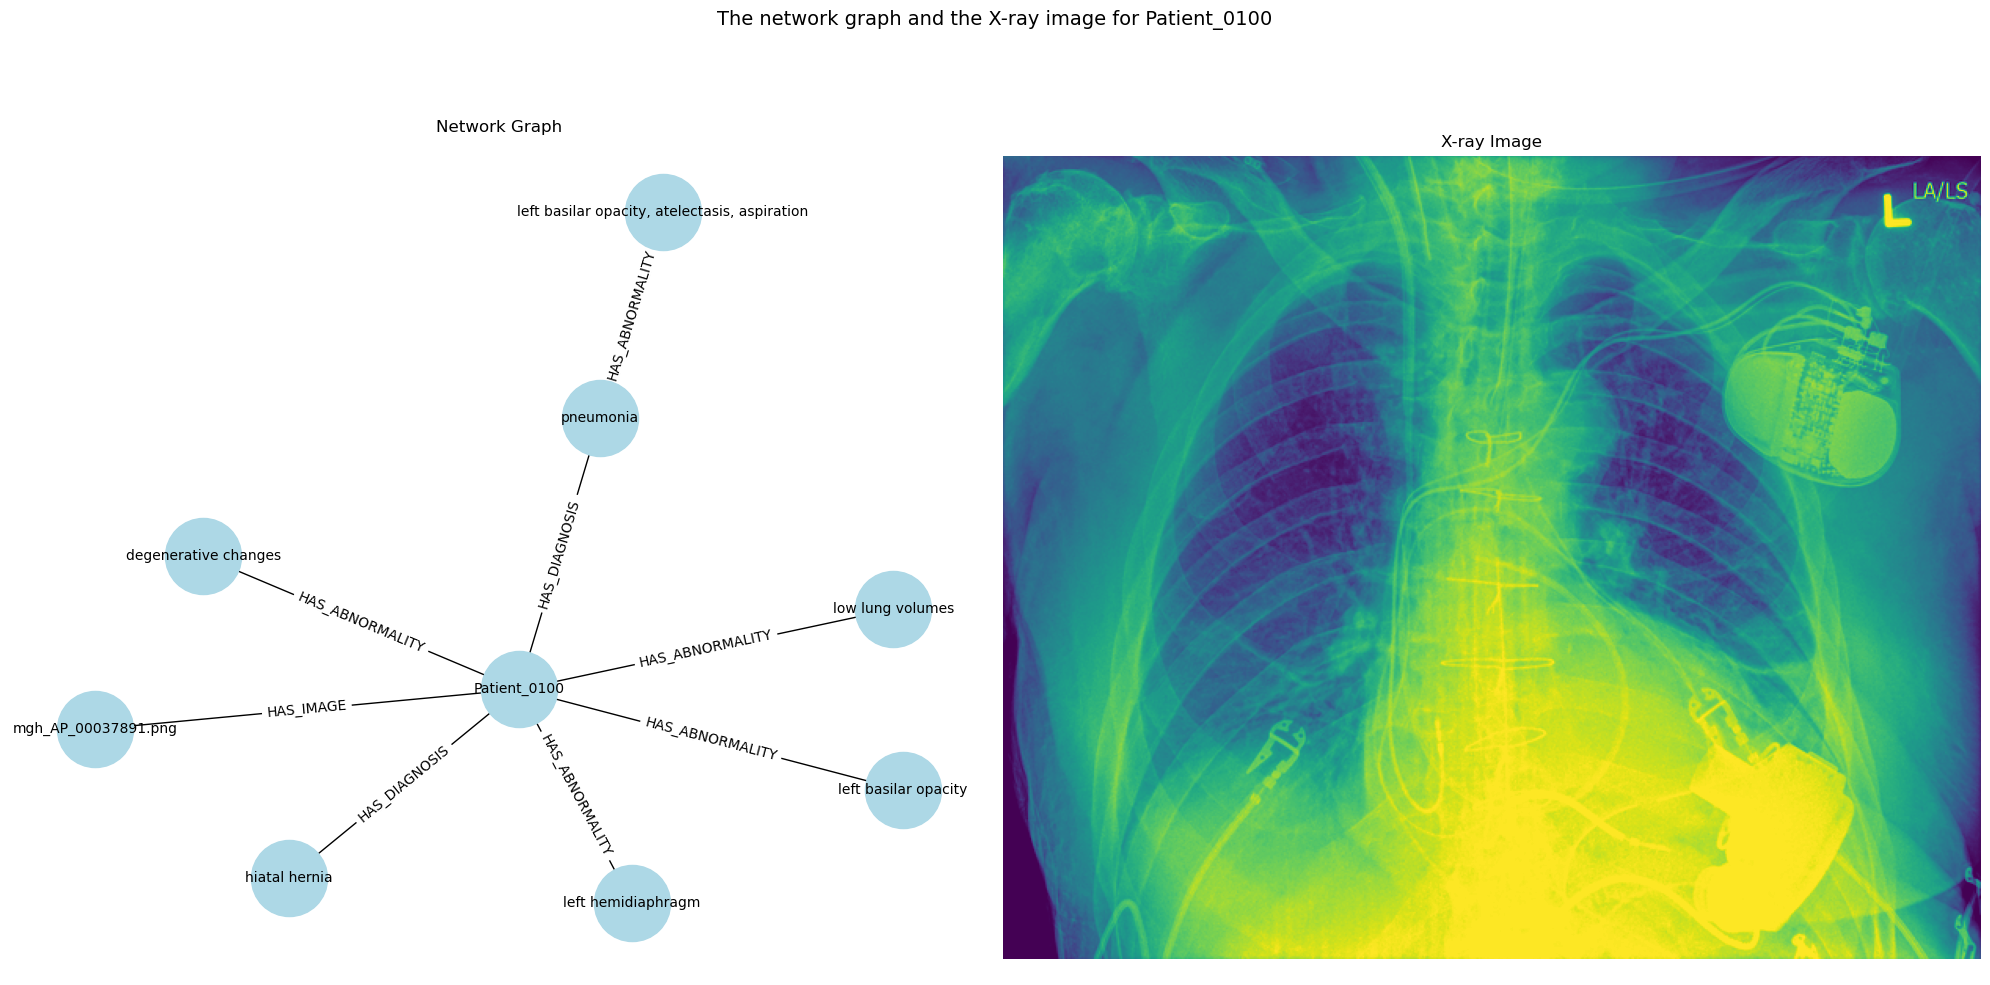

In [13]:
#### Extract the disease information, plot the network graoh, visualize the X-ray image for a specific patient from the graohic database 

import json
import networkx as nx
import matplotlib.pyplot as plt
from networkx.readwrite import json_graph
from textwrap import wrap
from PIL import Image
import os

# Load the JSON file containing the graphs
with open('all_graphs.json', 'r') as f:
    graphs_dict = json.load(f)

# Specify the patient ID
specified_patient_id = "Patient_0100"

# Base directory for X-ray images (update with the correct path)
xray_image_dir = os.path.join(base_dir, "ProgrammingTest_Data/png")

# Check if the patient exists in the data
if specified_patient_id in graphs_dict:
    patient_graph = graphs_dict[specified_patient_id]
    
    # Extract nodes and edges
    nodes = patient_graph.get("nodes", [])
    edges = patient_graph.get("links", [])
    
    # Initialize variables to store disease and image file name
    disease = None
    image_file_name = None
    
    # Loop through the edges to find relationships
    for edge in edges:
        source = edge.get("source")
        target = edge.get("target")
        relationship = edge.get("relationship")
        
        # Check for disease
        if relationship == "HAS_DIAGNOSIS" and source == specified_patient_id:
            disease = target
        
        # Check for image file name
        if relationship == "HAS_IMAGE" and source == specified_patient_id:
            image_file_name = target
    
    # Load the network graph
    subgraph = json_graph.node_link_graph(patient_graph)
    
    # Debugging: Check the graph structure
    print("Nodes in graph:", subgraph.nodes())
    print("Edges in graph:", subgraph.edges())
    
    if specified_patient_id not in subgraph.nodes():
        raise ValueError(f"Node '{specified_patient_id}' is not in the graph.")
    
    # Generate positions for the nodes
    pos = nx.spring_layout(subgraph)
    edge_labels = nx.get_edge_attributes(subgraph, 'relationship')
    
    # Load the X-ray image
    xray_image_path = os.path.join(xray_image_dir, image_file_name)
    if os.path.exists(xray_image_path):
        xray_image = Image.open(xray_image_path)
    else:
        raise FileNotFoundError(f"X-ray image not found at {xray_image_path}")
    
    # Create a figure with subplots
    fig, axs = plt.subplots(1, 2, figsize=(20, 10))  # 1 row, 2 columns
    
    # Create the dynamic title for the plot
    figure_title = f"The network graph and the X-ray image for {specified_patient_id}"
    wrapped_figure_title = "\n".join(wrap(figure_title, 100))  # Wrap the title text to 100 characters per line
    
    # Set the super title of the figure
    fig.suptitle(wrapped_figure_title, fontsize=14)
    
    # Plot the network graph in the first subplot
    axs[0].set_title("Network Graph")
    nx.draw(subgraph, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=10, ax=axs[0])
    nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, ax=axs[0])
    
    # Plot the X-ray image in the second subplot
    axs[1].imshow(xray_image)
    axs[1].set_title("X-ray Image")
    axs[1].axis('off')  # Hide the axes for the image
    
    # Adjust layout to make room for the suptitle and ensure titles are visible
    plt.tight_layout()
    fig.subplots_adjust(top=0.85)
    plt.show()
        
else:
    print(f"Patient {specified_patient_id} not found in the data.")





Patients with the disease 'cancer':
Patient_0425, Patient_0472, Patient_0535, Patient_0713, Patient_0839, Patient_0963, Patient_1087, Patient_1088, Patient_1440, Patient_1767, Patient_1781, Patient_1934


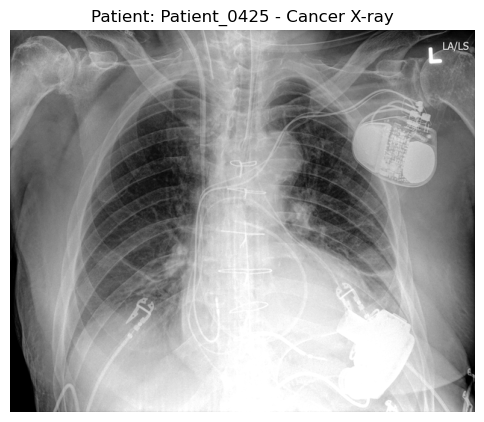

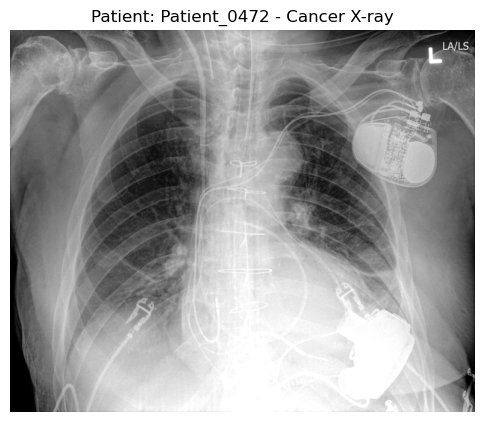

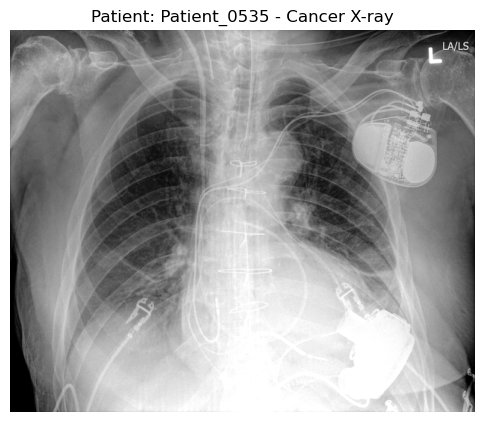

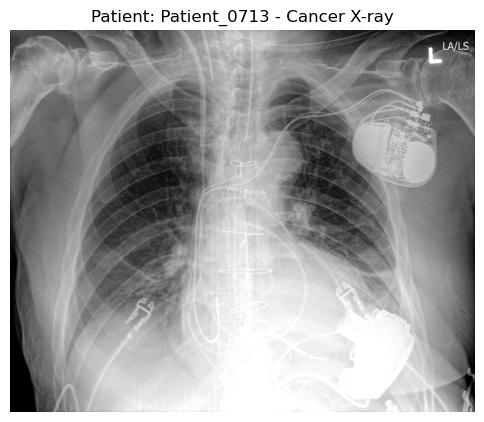

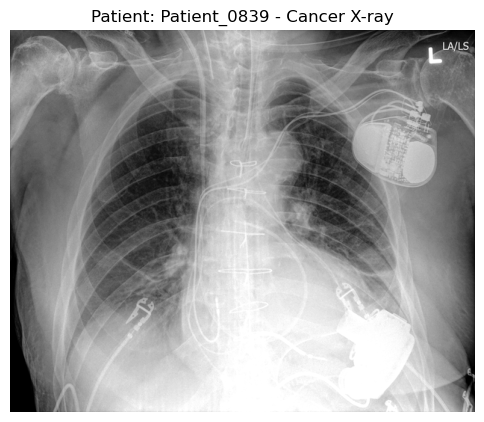

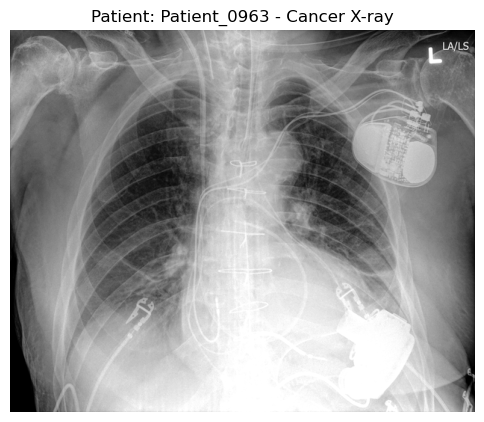

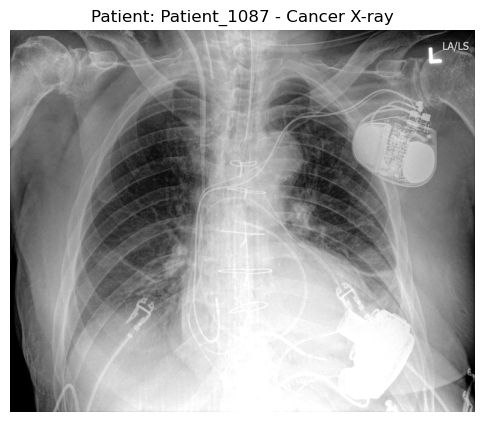

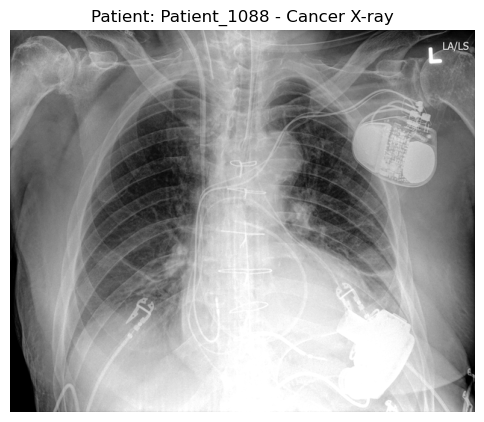

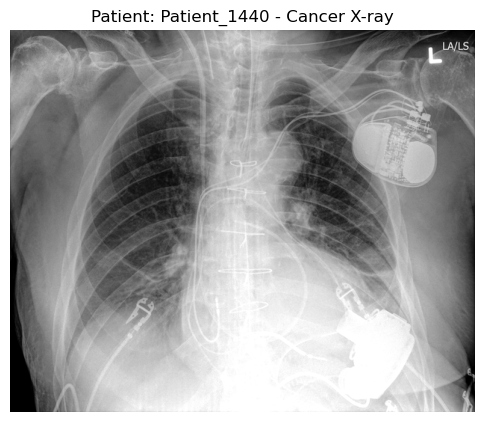

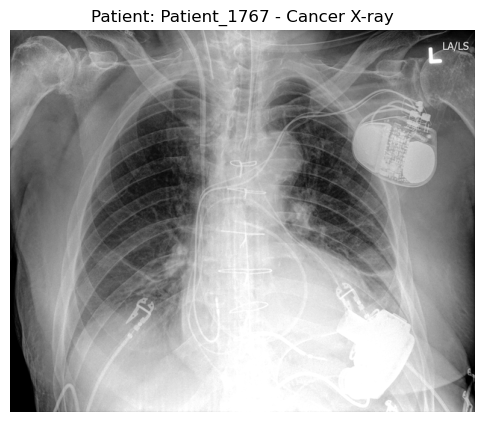

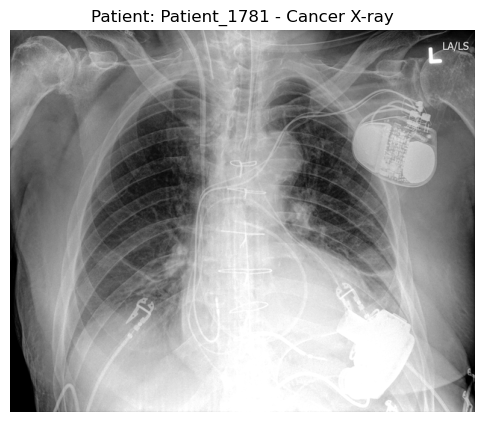

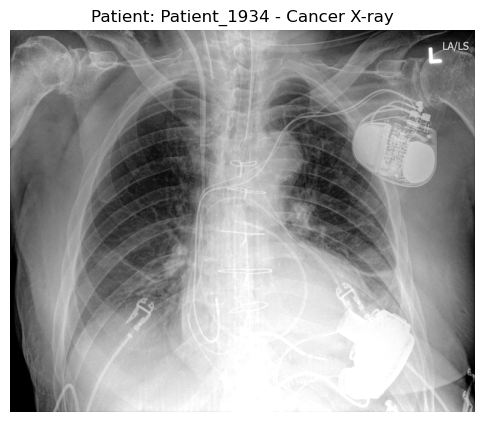

In [14]:
#### find all patients with the disease "cancer" from the graph database
import json
import matplotlib.pyplot as plt
import os
from PIL import Image


## Load the JSON file containing the graphs
with open('all_graphs.json', 'r') as f:
    graphs_dict = json.load(f)

## Define the disease to search for
target_disease = "cancer"
patients_with_disease = {}

## Iterate through all graphs
for patient_id, graph_data in graphs_dict.items():
    # Get edges (links) for this patient
    edges = graph_data.get("links", [])
    nodes = graph_data.get("nodes", [])
    
    # Find the X-ray image file name
    xray_image_filename = None
    for edge in edges:
        if edge.get("relationship") == "HAS_IMAGE" and edge.get("source") == patient_id:
            xray_image_filename = edge.get("target")
            break
    
    # Check for the target disease
    for edge in edges:
        if edge.get("relationship") == "HAS_DIAGNOSIS" and target_disease in edge.get("target", "").lower():
            if xray_image_filename:
                patients_with_disease[patient_id] = xray_image_filename
            break

# Output the results
if patients_with_disease:
    print(f"Patients with the disease '{target_disease}':")
    print(", ".join(patients_with_disease))
else:
    print(f"No patients with the disease '{target_disease}' found.")

# Plot X-ray image of the patients with the tarfet disease
xray_image_dir = os.path.join(base_dir, 'ProgrammingTest_Data/png/')

## Create the dynamic title for the plot
## Set the super title of the figure
figure_title = f"The X-ray image for patients have cancer"
wrapped_figure_title = "\n".join(wrap(figure_title, 100))  # Wrap the title text to 100 characters per line
fig.suptitle(wrapped_figure_title, fontsize=14)

if patients_with_disease:
    for patient_id, image_filename in patients_with_disease.items():
        image_path = os.path.join(xray_image_dir, image_filename)
        
        # Check if the image file exists
        if os.path.exists(image_path):
            # Load and display the image
            img = Image.open(image_path)
            plt.figure(figsize=(6, 6))
            plt.imshow(img, cmap="gray")
            plt.axis("off")
            plt.title(f"Patient: {patient_id} - {target_disease.capitalize()} X-ray")
            plt.show()
        else:
            print(f"Image file for {patient_id} not found at {image_path}")
else:
    print(f"No X-ray images found for patients with the disease '{target_disease}'.")


In [ ]:
#### Orgnizing and labeling the data for AI modeling

import os
import shutil
from sklearn.model_selection import train_test_split

## Fing the image files with cancer
with open('all_graphs.json', 'r') as f:
    graphs_dict = json.load(f)


# Directories for cancer and no_cancer images
cancer_dir = os.path.join(base_dir, "cancer_modeling/cancer")
no_cancer_dir = os.path.join(base_dir, "cancer_modeling/no_cancer")
os.makedirs(cancer_dir, exist_ok=True)
os.makedirs(no_cancer_dir, exist_ok=True)

# Filter cancer and non-cancer images based on the graph database
original_image_dir = os.path.join(base_dir, 'ProgrammingTest_Data/png')
cancer_images = []
no_cancer_images = []
for patient_id, graph_data in graphs_dict.items():
    edges = graph_data.get("links", [])
    image_file = None
    has_cancer = False

    # Find the image file and check for a cancer diagnosis
    for edge in edges:
        if edge.get("relationship") == "HAS_IMAGE":
            image_file = edge.get("target")
        if edge.get("relationship") == "HAS_DIAGNOSIS" and "cancer" in edge.get("target", "").lower():
            has_cancer = True

    # Add the image path to the appropriate list
    if image_file:
        image_path = os.path.join(original_image_dir, image_file)
        if os.path.exists(image_path):
            if has_cancer:
                cancer_images.append(image_path)
            else:
                no_cancer_images.append(image_path)

# Copy images to cancer and no_cancer directories
for image_path in cancer_images:
    shutil.copy(image_path, os.path.join(cancer_dir, os.path.basename(image_path)))

for image_path in no_cancer_images:
    shutil.copy(image_path, os.path.join(no_cancer_dir, os.path.basename(image_path)))

# Dataset split directories
split_base_dir = os.path.join(base_dir, "cancer_modeling/split_dataset")
train_dir = os.path.join(split_base_dir, "train")
val_dir = os.path.join(split_base_dir, "val")
test_dir = os.path.join(split_base_dir, "test")

# Create subdirectories for train, val, and test
for split in [train_dir, val_dir, test_dir]:
    os.makedirs(os.path.join(split, "cancer"), exist_ok=True)
    os.makedirs(os.path.join(split, "no_cancer"), exist_ok=True)

# Get the file paths in the cancer and no_cancer directories
cancer_images = [os.path.join(cancer_dir, f) for f in os.listdir(cancer_dir) if os.path.isfile(os.path.join(cancer_dir, f))]
no_cancer_images = [os.path.join(no_cancer_dir, f) for f in os.listdir(no_cancer_dir) if os.path.isfile(os.path.join(no_cancer_dir, f))]

# Split datasets (80% train, 10% val, 10% test)
train_cancer, temp_cancer = train_test_split(cancer_images, test_size=0.2, random_state=42)
val_cancer, test_cancer = train_test_split(temp_cancer, test_size=0.5, random_state=42)

train_no_cancer, temp_no_cancer = train_test_split(no_cancer_images, test_size=0.2, random_state=42)
val_no_cancer, test_no_cancer = train_test_split(temp_no_cancer, test_size=0.5, random_state=42)

# Helper function to copy files to their respective directories
def copy_files(file_list, destination_dir):
    for file_path in file_list:
        shutil.copy(file_path, destination_dir)

# Copy files to train, val, test directories
copy_files(train_cancer, os.path.join(train_dir, "cancer"))
copy_files(val_cancer, os.path.join(val_dir, "cancer"))
copy_files(test_cancer, os.path.join(test_dir, "cancer"))

copy_files(train_no_cancer, os.path.join(train_dir, "no_cancer"))
copy_files(val_no_cancer, os.path.join(val_dir, "no_cancer"))
copy_files(test_no_cancer, os.path.join(test_dir, "no_cancer"))

print("Dataset preparation complete.")


In [ ]:
#### Train the AI model

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import os


# Image preprocessing and augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

# Load ResNet50 model pre-trained on ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Add custom layers for binary classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator)
)

# Save the trained model
model.save("cancer_model.h5")

print("Model training complete and saved to 'cancer_model.h5'")


In [ ]:
#### Evaluate the model

# Load the test dataset
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


In [ ]:
#### Visualizing the training result

import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()
